# 0.0 Imports

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import inflection
from pandas_profiling import ProfileReport
from boruta import BorutaPy

from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_score,recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

from IPython.display import Image
from IPython.core.display import HTML
import warnings
warnings.filterwarnings('ignore')

## 0.1 Helper functions

In [2]:
# def jupyter_settings():
#     %matplotlib inline
#     %pylab inline
    
#     plt.style.use( 'bmh' )
#     plt.rcParams['figure.figsize'] = [25, 12]
#     plt.rcParams['font.size'] = 24
    
#     display( HTML( '<style>.container { width:100% !important; }</style>') )
#     pd.options.display.max_columns = None
#     pd.options.display.max_rows = None
#     pd.set_option( 'display.expand_frame_repr', False )
    
#     sns.set()
# jupyter_settings()

In [3]:
def cross_validation(X_train, y_train, n_folds, model_name, model, verbose=True):
    # generate k-fold
    f1_scores = []
    n_folds = n_folds
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    i=1
    if verbose:
        for train_ix, val_ix in kfold.split(X_train, y_train):
            print('Fold Nº: {}/{}'.format(i, n_folds))
            # get fold
            X_train_fold = X_train.iloc[train_ix]
            y_train_fold = y_train.iloc[train_ix]

            X_val_fold = X_train.iloc[val_ix]
            y_val_fold = y_train.iloc[val_ix]


            # training model
            m = model.fit(X_train_fold, y_train_fold)

            # prediction
            pred_val = m.predict(X_val_fold)

            # metric
            # F1-Score
            f1_fold = f1_score(pred_val,y_val_fold)
            f1_scores.append(f1_fold)

            i +=1
    return pd.DataFrame({'Model Name': model_name,
                         'Avg F1-Score':np.round(np.mean(f1_scores),3).astype(str)+ '+/-' + np.round(np.std(f1_scores),3).astype(str)}, index=[0])

In [4]:
def f1_score_metric(model_name, y_test, pred):
    return pd.DataFrame({'Model Name': model_name,
                        'F1 Score': f1_score(pred,y_test).round(3)}, index=[0])

## 0.2 Load Data

In [5]:
df = pd.read_csv('..\churn.csv')
df.drop('RowNumber', axis=1, inplace=True)

# 1.0 Data Description

In [6]:
df1 = df.copy()

## 1.1 Features' Description

* RowNumber: O número da coluna
* CustomerID: Identificador único do cliente
* Surname: Sobrenome do cliente.
* CreditScore: A pontuação de Crédito do cliente para o mercado de consumo.
* Geography: O país onde o cliente reside.
* Gender: O gênero do cliente.
* Age: A idade do cliente.
* Tenure: Número de anos que o cliente permaneceu ativo.
* Balance: Valor monetário que o cliente tem em sua conta bancária.
* NumOfProducts: O número de produtos comprado pelo cliente no banco.
* HasCrCard: Indica se o cliente possui ou não cartão de crédito.
* IsActiveMember: Indica se o cliente fez pelo menos uma movimentação na conta bancário dentro de 12 meses.
* EstimateSalary: Estimativa do salário mensal do cliente.
* Exited: Indica se o cliente está ou não em Churn.

In [7]:
df1.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 1.1 Data Dimensions

In [8]:
print('The dataset contains {} rows'. format(df1.shape[0]))
print('The dataset contains {} columns'. format(df1.shape[1]))

The dataset contains 10000 rows
The dataset contains 13 columns


## 1.2 Rename Columns

In [9]:
cols_old = df1.columns.to_list()

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.3 Data Types

In [10]:
# Data types seem correct by default
df1.dtypes

customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 1.4 Null  Values

In [11]:
# No NAs
df1.isna().sum()

customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 1.5 Descriptive Statistics

In [12]:
num = df1.select_dtypes(include=['int64','float64'])
cat = df1.select_dtypes(exclude=['int64','float64'])

### 1.5.1 Numerical Variables

In [13]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame(num.apply(np.mean)).T
ct2 = pd.DataFrame(num.apply(np.median)).T

# Dispersion - standard desviatiom, skew, kurtosis, min, max, range
d1 = pd.DataFrame(num.apply(min)).T
d2 = pd.DataFrame(num.apply(max)).T
d3 = pd.DataFrame(num.apply(lambda x: x.max()-x.min())).T
d4 = pd.DataFrame(num.apply(np.std)).T
d5 = pd.DataFrame(num.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num.apply(lambda x: x.kurtosis())).T

ctd = pd.concat([ct1,ct2,d1,d2,d3,d4,d5,d6]).T.reset_index()
ctd.columns = ['features', 'mean','median','min','max','range','std','skew','kurtosis']
ctd.drop([0], inplace=True) # Drop customer_id
ctd

,features,mean,median,min,max,range,std,skew,kurtosis
1,credit_score,650.528800,652.000,350.00,850.00,500.00,96.648466,-0.071607,-0.425726
2,age,38.921800,37.000,18.00,92.00,74.00,10.487282,1.011320,1.395347
3,tenure,5.012800,5.000,0.00,10.00,10.00,2.892030,0.010991,-1.165225
4,balance,76485.889288,97198.540,0.00,250898.09,250898.09,62394.285254,-0.141109,-1.489412
5,num_of_products,1.530200,1.000,1.00,4.00,3.00,0.581625,0.745568,0.582981
6,has_cr_card,0.705500,1.000,0.00,1.00,1.00,0.455818,-0.901812,-1.186973
7,is_active_member,0.515100,1.000,0.00,1.00,1.00,0.499772,-0.060437,-1.996747
8,estimated_salary,100090.239881,100193.915,11.58,199992.48,199980.90,57507.617221,0.002085,-1.181518
9,exited,0.203700,0.000,0.00,1.00,1.00,0.402748,1.471611,0.165671


**NOTES**
* May filter low salary clients
* May filter low balance clients

### 1.5.1 Categorical Variables

In [14]:
cat.apply(lambda x:x.nunique())

surname      2932
geography       3
gender          2
dtype: int64

In [15]:
# Countries 
cat.geography.value_counts()

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

In [16]:
# Gender
cat.gender.value_counts()

Male      5457
Female    4543
Name: gender, dtype: int64

# 2.0 Feature Engeenering

In [17]:
df2 = df1.copy()

## 2.1 Mind Map

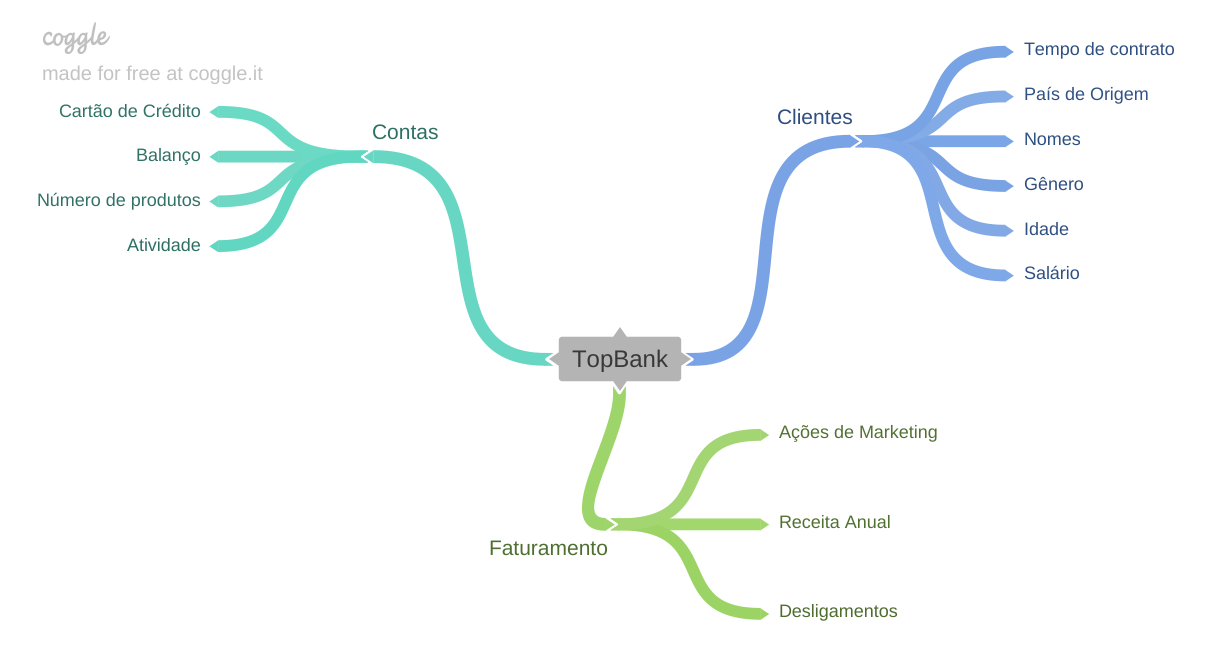

In [18]:
Image('topban-hypothesis.png')

## 2.2 Hypothesis

Faturamento
* Quanto maior o credit score, maior o faturamento
* Quanto mais anos de contrato, maior o faturamento
* Quanto maior o número de produtos, maior o faturamento
* Se possui cartao de crédito, maior é o faturamento

Contas
* Quanto maior o salário maior o credit_score
* Quanto maior o balanço maior o credit_score
* Quanto maior o numéro de produtos maior o credit score
* Quanto maior o numéro de produtos, mais anos de contrato
* Se não é membro ativo significa que entrou em churn.
* Quanto mais anos de contrato, menor a proporção de churn

Clientes
* Homens possuem balanços maiores que mulheres
* Homens possuem salários maiores que mulheres
* Quanto mais velho o cliente, maior a probabilidade de ter mais anos de contrato
* Quanto mais velho o cliente, maior a probabilidade de ter um balanço alto
* Quanto mais velho o cliente, maior a probabilidade de ter um salário alto

## 2.3 Feature Creation

### 2.3.1 Annual Revenue (per customer)

In [19]:
## Try - List comprehension
# df2['anual_revenue'] = [ (salary *0.15) if (salary < df2['estimated_salary'].mean()) else (salary *0.20) if (salary > df2['estimated_salary'].mean()) for salary in df2['estimated_salary']]

anual_revenue = []
for salary in df2['estimated_salary']:
    if salary < df2['estimated_salary'].mean():
        anual_revenue.append(salary*0.15)
    elif salary > df2['estimated_salary'].mean():
        anual_revenue.append(salary*0.20)
df2['anual_revenue'] = pd.Series(anual_revenue)

# 3.0 Feature Filtering

In [20]:
df3 = df2.copy()

## 3.1 Column Filtering

In [21]:
# Drop customer_id and surname
df3.drop(['customer_id','surname'], axis=1, inplace=True)

In [22]:
df3[df3.estimated_salary<1000].is_active_member.value_counts()

1    36
0    23
Name: is_active_member, dtype: int64

# 4.0 EAD (Exploratory Data Analysis)

In [23]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Numerical Variables

**Churn**

In [24]:
print('There are {} customers in churn.'.format(df4.exited.value_counts()[1]))
print('This represents {:.1%} percent of the customer base'.format(df4.exited.value_counts()[1]/df4.shape[0]))

There are 2037 customers in churn.
This represents 20.4% percent of the customer base


**Active account**

In [25]:
print('There are {} that have not done any account moviment in the last year.'.format(df4.is_active_member.value_counts()[0]))
print('This represents {:.1%} percent of the customer base'.format(df4.is_active_member.value_counts()[0]/df4.shape[0]))

There are 4849 that have not done any account moviment in the last year.
This represents 48.5% percent of the customer base


**NOTE**: This might mean that, first, not active clients may have a higher probability to become churn at the end of the contract and, second, MANY customers may become churn in the future.

**Tenure**

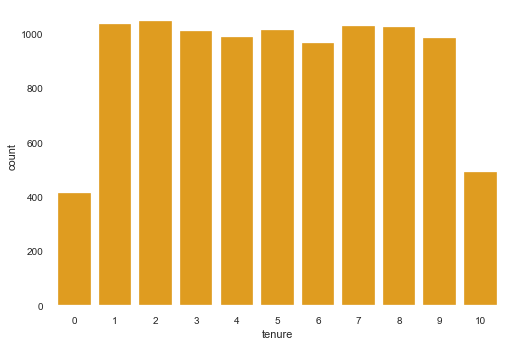

In [26]:
sns.countplot(df4.tenure, color='orange');
# Quite similar distribuition of tenure year 

**Age**

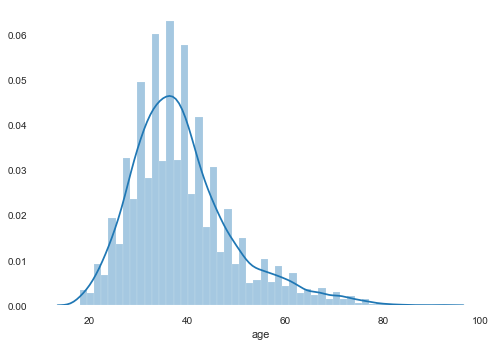

In [27]:
sns.distplot(df4.age);

**Number of Products**

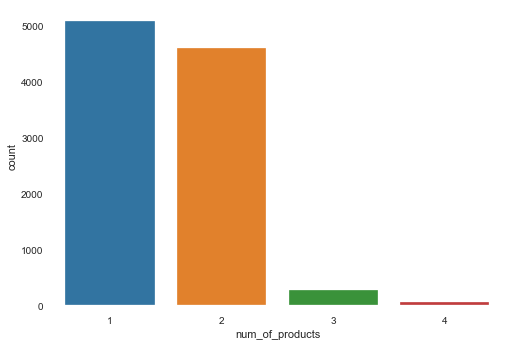

In [28]:
sns.countplot(df4.num_of_products);
# The vast majority of clients only have 1-to-2 products

**Credit Card**

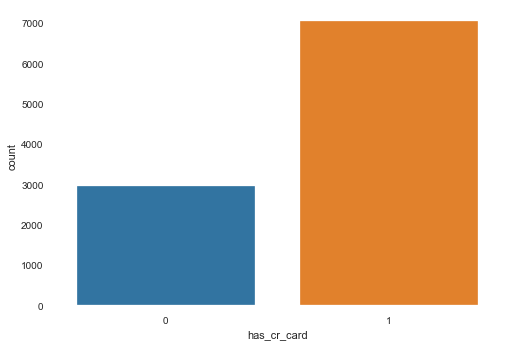

In [29]:
sns.countplot(df4.has_cr_card);
# Most customers use credit card

**Credit Score**

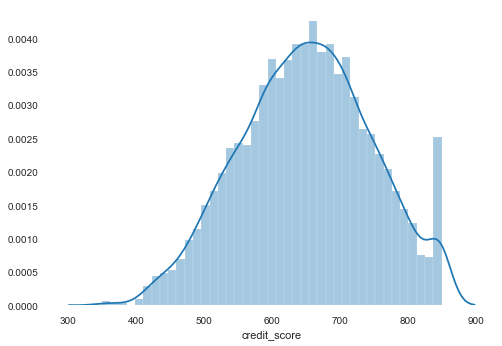

In [30]:
sns.distplot(df4.credit_score);

**Balance**

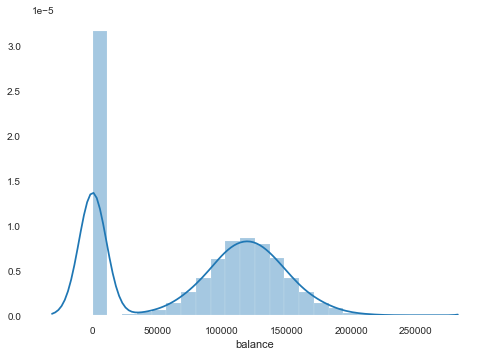

In [31]:
sns.distplot(df4.balance);

**NOTE**
* Great number of low balance customer may indicate future churs.

**Estimated Salary**

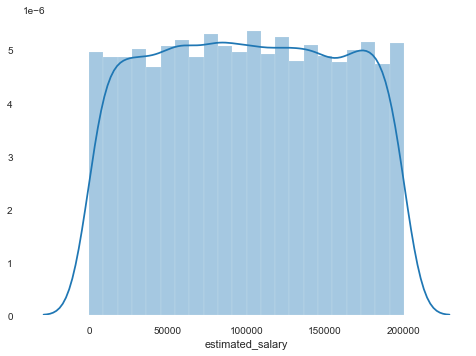

In [32]:
sns.distplot(df4.estimated_salary);

**Anual Revenue**

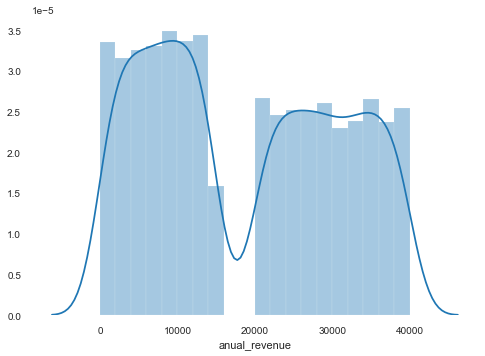

In [33]:
sns.distplot(df4.anual_revenue);
# I guess this shape is resulted from not using the estimated salary mean itself in the calculation 

count    10000.000000
mean     18761.207750
std      12313.366213
min          1.737000
25%       7650.316500
50%      20038.783000
75%      29877.649500
max      39998.496000
Name: anual_revenue, dtype: float64


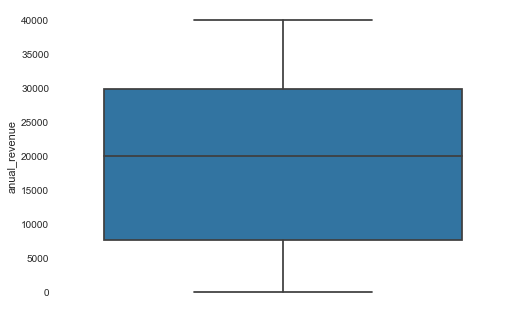

In [34]:
print(df4.anual_revenue.describe())
sns.boxplot(y=df4.anual_revenue);

### 4.1.2 Categorical Variables

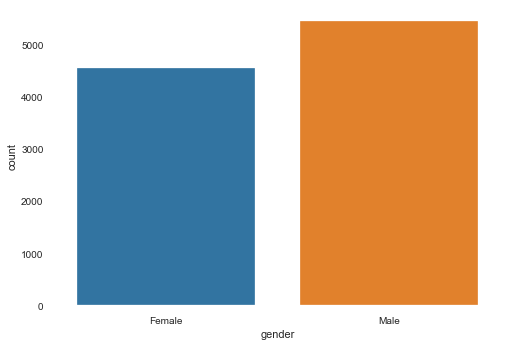

In [35]:
sns.countplot(df4.gender);
# Most customers are male.

**Countries**

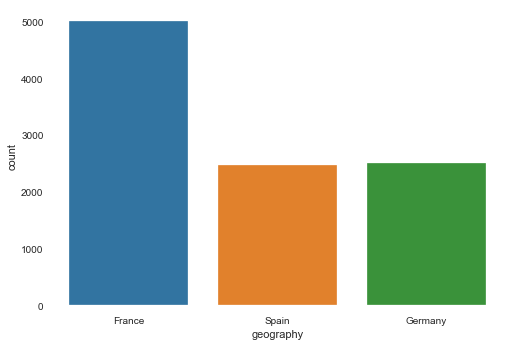

In [36]:
sns.countplot(df4.geography);
# Most customers are from France

### 4.1.3 Pandas Profiling

In [37]:
#profile = ProfileReport(df4, title='TopBanck Churn Analysis - Exploratory Data Analysis', html={'style':{'full_width':True}})
#profile.to_file(output_file="EDA.html")

**Notes**
* 36,2% of the customers (3617) have a zero `balance`
* High number of clients that have a 10 year `tenure` (??????)
* `credit_score` has almost a normal distribuition
* High number of inactive members in`is_active_member` (4894) --> Deeper the analysis
* HIGH IMBALANCE in `exited` -> 20% churn / 80% not churn.


## 4.2 Bivariate Analysis

Faturamento
* Quanto maior o credit score, maior o faturamento
* Quanto mais anos de contrato, maior o faturamento
* Quanto maior o número de produtos, maior o faturamento
* Se possui cartao de crédito, maior é o faturamento

Contas
* Quanto maior o salário maior o credit_score
* Quanto maior o balanço maior o credit_score
* Quanto maior o numéro de produtos maior o credit score
* Quanto maior o numéro de produtos, mais anos de contrato
* Se não é membro ativo significa que entrou em churn.
* Quanto mais anos de contrato, menor a proporção de churn

Clientes
* Homens possuem maior média de balanços que mulheres
* Homens possuem maior média salarial que mulheres
* Quanto mais velho o cliente, maior o número de anos de contrato
* Quanto mais velho o cliente, maior o balanço
* Quanto mais velho o cliente, maior o salário.

### 4.2.1 Clientes

**Homens possuem maior média de balanços que mulheres.**

**R: Verdadeiro, homens possuem maior média de balanço que mulheres. Ainda que sejam muito próximos**

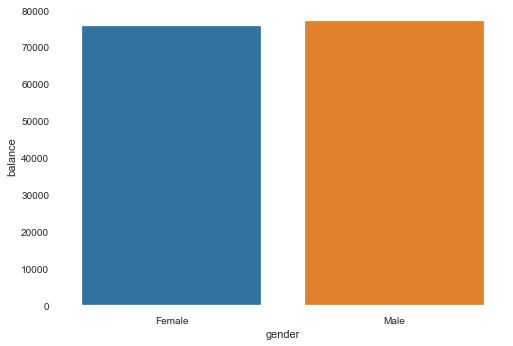

In [38]:
# Homens possuem maior média de balanços que mulheres

aux1 = df4[['gender','balance']].groupby('gender').mean().reset_index()
sns.barplot(x='gender',y='balance', data=aux1);


**Homens possuem média salarial maior que mulheres**

**R: Falso, mulheres possuem uma média salarial maior que homens, ainda que sejam muito próximos.**

   gender  estimated_salary
0  Female     100601.541382
1    Male      99664.576931


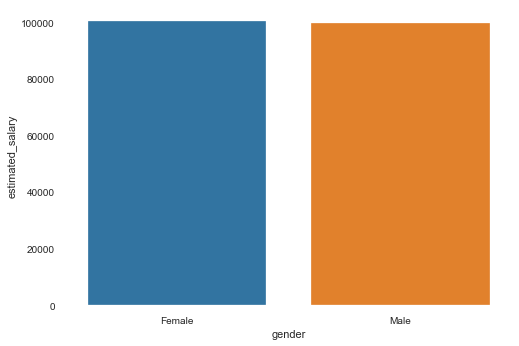

In [39]:
# Homens possuem média salarial maior que mulheres

aux2 = df4[['gender','estimated_salary']].groupby('gender').mean().reset_index()
print(aux2)
sns.barplot(x='gender',y='estimated_salary', data=aux2);

**Quanto mais velho o cliente, mais anos de contrato.**

**R: Falso, não há evidência de que quanto mais velho o cliente, maior o número de anos do contrato.**

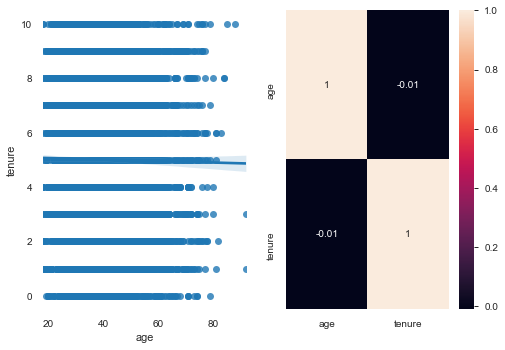

In [40]:
# Quanto mais velho o cliente, mais anos de contrato.

plt.subplot(1,2,1)
sns.regplot(x='age',y='tenure',data=df4);

plt.subplot(1,2,2)
sns.heatmap(df4[['age','tenure']].corr(method='pearson'), annot=True);

**Quanto mais velho o cliente, maior o balanço**

**R: Falso, não há evidências de que quanto mais velhor o cliente, maior o balanço**

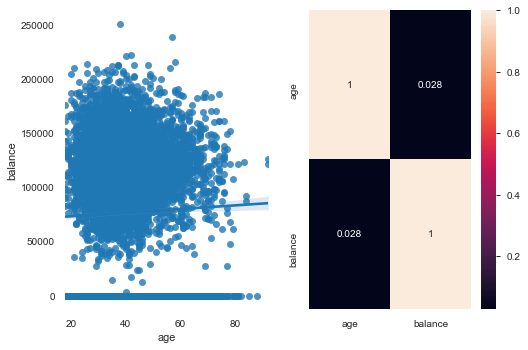

In [41]:
# Quanto mais velho o cliente, maior o balanço alto
plt.subplot(1,2,1)
sns.regplot(x='age',y='balance', data=df4);

plt.subplot(1,2,2)
sns.heatmap(df4[['age','balance']].corr(method='pearson'),annot=True);

**Quanto mais velho o cliente, maior o salário**

**R: Falso, não há evidênica de que quanto mais velho o cliente, amior seja o salário.**

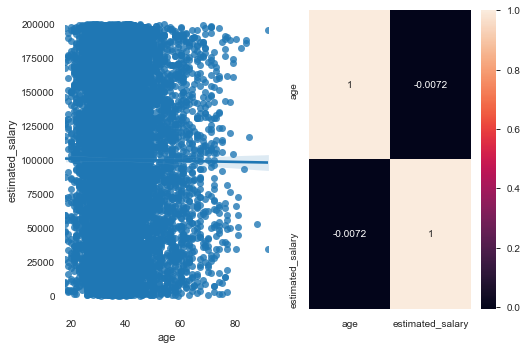

In [42]:
# Quanto mais velho o cliente, maior a probabilidade de ter um salário alto
plt.subplot(1,2,1)
sns.regplot(x='age',y='estimated_salary',data=df4);

plt.subplot(1,2,2)
sns.heatmap(df4[['age','estimated_salary']].corr(method='pearson'),annot=True);

### 4.2.2. Contas

**Quanto maior o salário maior o credit_score.**

**R: Falso, não há correlação alguma entre salário e credit score.**


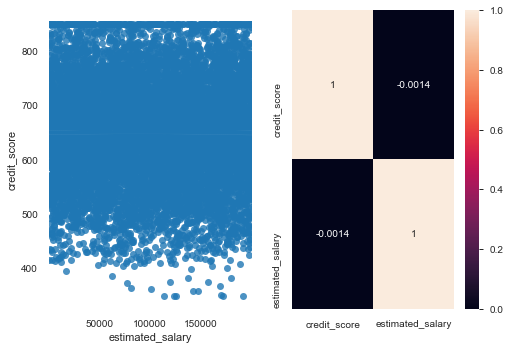

In [43]:
# Quanto maior o salário maior o credit_score.
plt.subplot(1,2,1)
sns.regplot(x='estimated_salary',y='credit_score',data=df4);

plt.subplot(1,2,2)
sns.heatmap(df4[['credit_score','estimated_salary']].corr(method='pearson'),annot=True);

**Quanto maior o balanço maior o credit_score**

**R: Falso, não correlação entre maior balanço e maior credito score**

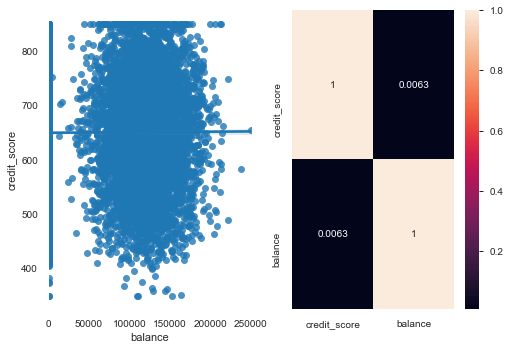

In [44]:
# Quanto maior o balanço maior o credit_score
plt.subplot(1,2,1)
sns.regplot(x='balance',y='credit_score',data=df4);

plt.subplot(1,2,2)
sns.heatmap(df4[['credit_score','balance']].corr(method='pearson'),annot=True);

**Quanto maior o numéro de produtos maior o credit score**

**R: Falso, não há correlação entre ter um alto número de produtos e ter um alto credit score**


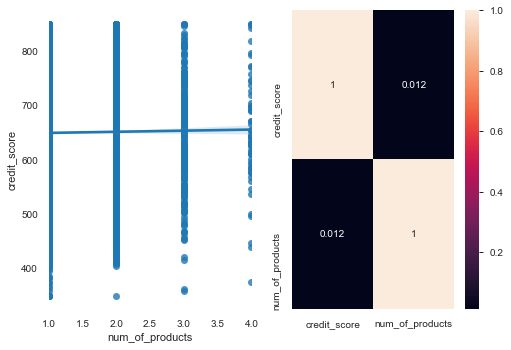

In [45]:
# Quanto maior o numéro de produtos maior o credit score
plt.subplot(1,2,1)
sns.regplot(x='num_of_products',y='credit_score',data=df4);

plt.subplot(1,2,2)
sns.heatmap(df4[['credit_score','num_of_products']].corr(method='pearson'),annot=True);

**Quanto maior o salário, maior o balanço**

**R: Falso, não há evidências de que um maior salário esteja correlacionado a um maior balanço.**

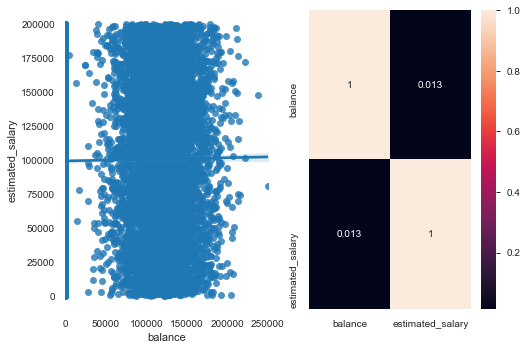

In [46]:
plt.subplot(1,2,1)
sns.regplot(x='balance',y='estimated_salary',data=df4);

plt.subplot(1,2,2)
sns.heatmap(df4[['balance','estimated_salary']].corr(method='pearson'),annot=True);

### 4.2.3 Faturamento

**Quanto maior o credit score, maior o faturamento**

**R: Falso, não há indícios para essa afirmação.**

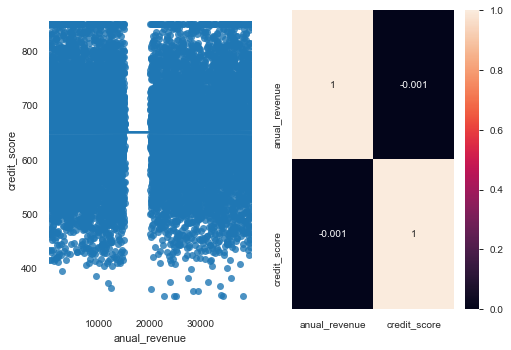

In [47]:
# Quanto maior o credit score, maior o faturamento

plt.subplot(1,2,1)
sns.regplot(x='anual_revenue', y='credit_score', data=df4);

plt.subplot(1,2,2)

sns.heatmap(df4[['anual_revenue','credit_score']].corr(method='pearson'),annot=True);

**Quanto mais anos de contrato, maior o faturamento**

**R: Falso, não há evidências nesse sentido.**

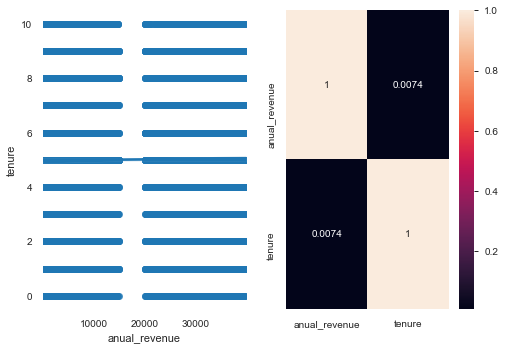

In [48]:
plt.subplot(1,2,1)
sns.regplot(x='anual_revenue', y='tenure', data=df4);

plt.subplot(1,2,2)

sns.heatmap(df4[['anual_revenue','tenure']].corr(method='pearson'),annot=True);

**Quanto maior o número de produtos, maior o faturamento**

**R: Falso, não há evidências nesse sentido.**

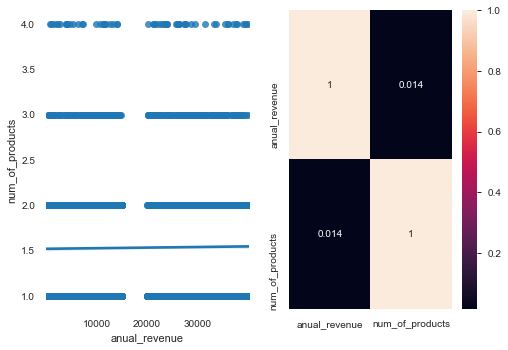

In [49]:
# Quanto maior o número de produtos, maior o faturamento
plt.subplot(1,2,1)
sns.regplot(x='anual_revenue', y='num_of_products', data=df4);

plt.subplot(1,2,2)

sns.heatmap(df4[['anual_revenue','num_of_products']].corr(method='pearson'),annot=True);

**Se possui cartao de crédito, maior é o faturamento**

**R: Falso, não há evidências nesse sentido.**

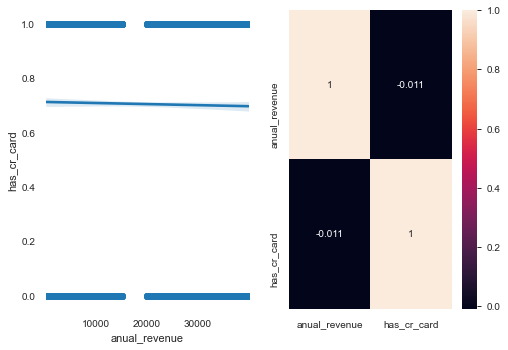

In [50]:
plt.subplot(1,2,1)
sns.regplot(x='anual_revenue', y='has_cr_card', data=df4);

plt.subplot(1,2,2)

sns.heatmap(df4[['anual_revenue','has_cr_card']].corr(method='pearson'),annot=True);

## 4.3 Churn Analysis

In [51]:
df_churn = df4[df4['exited']==1]
df_not_churn = df4[df4['exited']==0]

The churn dataset has more inactive customers as well as the not churn dataset has more active customers, which makes sense. It is important to notice that `df_not_churn` still has a significant amount of inactive customers, what might indicate that they may eventuallty become a churn by the end of their contracts.

### 4.3.1 Number of Active Members

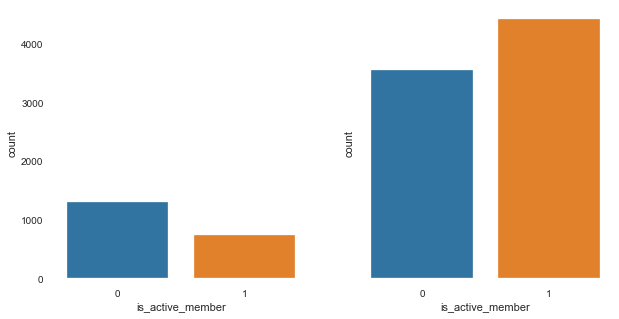

In [52]:
fig,ax = plt.subplots(1,2,figsize=(10,5),sharey=True)

sns.countplot(ax=ax[0],x=df_churn.is_active_member);
#plt.title('Active Members within Churn members')

sns.countplot(ax=ax[1],x=df_not_churn.is_active_member);
#plt.title('Active Members within Non-Churn members')


plt.show()

### 4.3.2 Balance

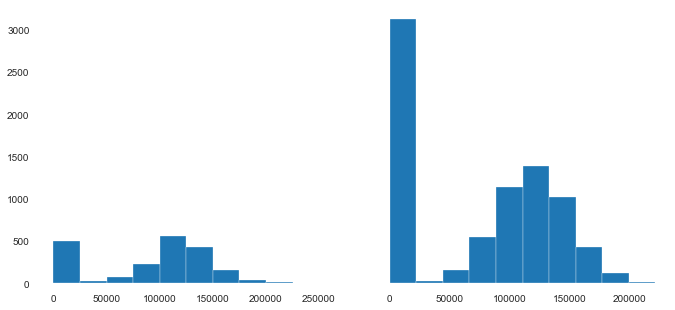

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,5), sharey=True)

fig.tight_layout(pad=3)
ax[0].hist(df_churn.balance);

ax[1].hist(df_not_churn.balance);


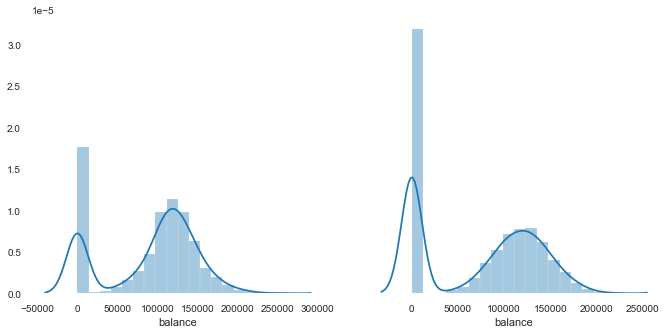

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,5), sharey=True)

fig.tight_layout(pad=3)
sns.distplot(ax=ax[0], a=df_churn.balance);

sns.distplot(ax=ax[1], a=df_not_churn.balance);

### 4.3.3 Estimated Salary

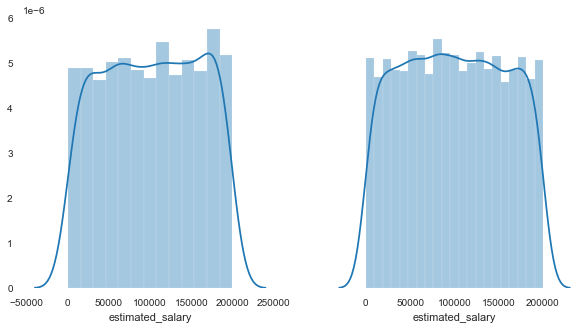

In [55]:
fig,ax = plt.subplots(1,2,figsize=(10,5), sharey=True)
sns.distplot(ax=ax[0],a=df_churn.estimated_salary);

sns.distplot(ax=ax[1],a= df_not_churn.estimated_salary);

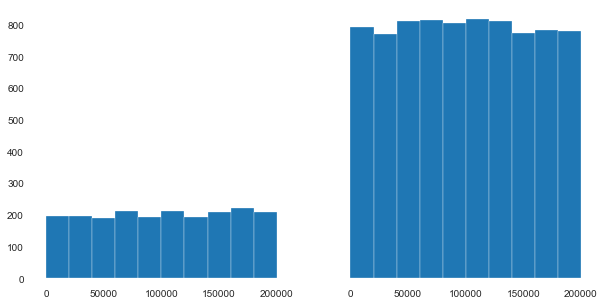

In [56]:
fig,ax = plt.subplots(1,2,figsize=(10,5), sharey=True)
ax[0].hist(df_churn.estimated_salary);

ax[1].hist(df_not_churn.estimated_salary);

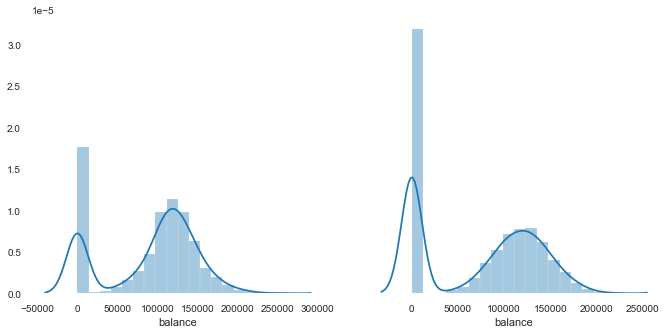

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,5), sharey=True)

fig.tight_layout(pad=3)
sns.distplot(ax=ax[0], a=df_churn.balance);

sns.distplot(ax=ax[1], a=df_not_churn.balance);


## 4.4 Multivariate Analysis

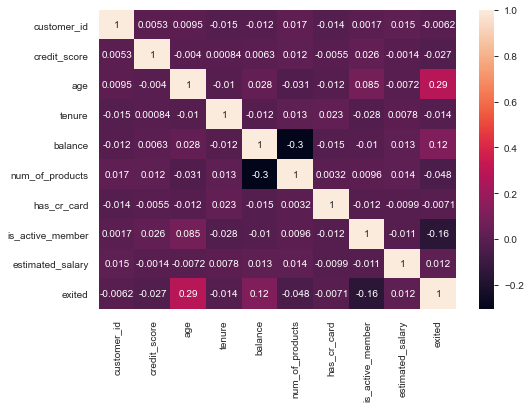

In [58]:
corr = num.corr(method='pearson')
sns.heatmap(corr, annot=True);

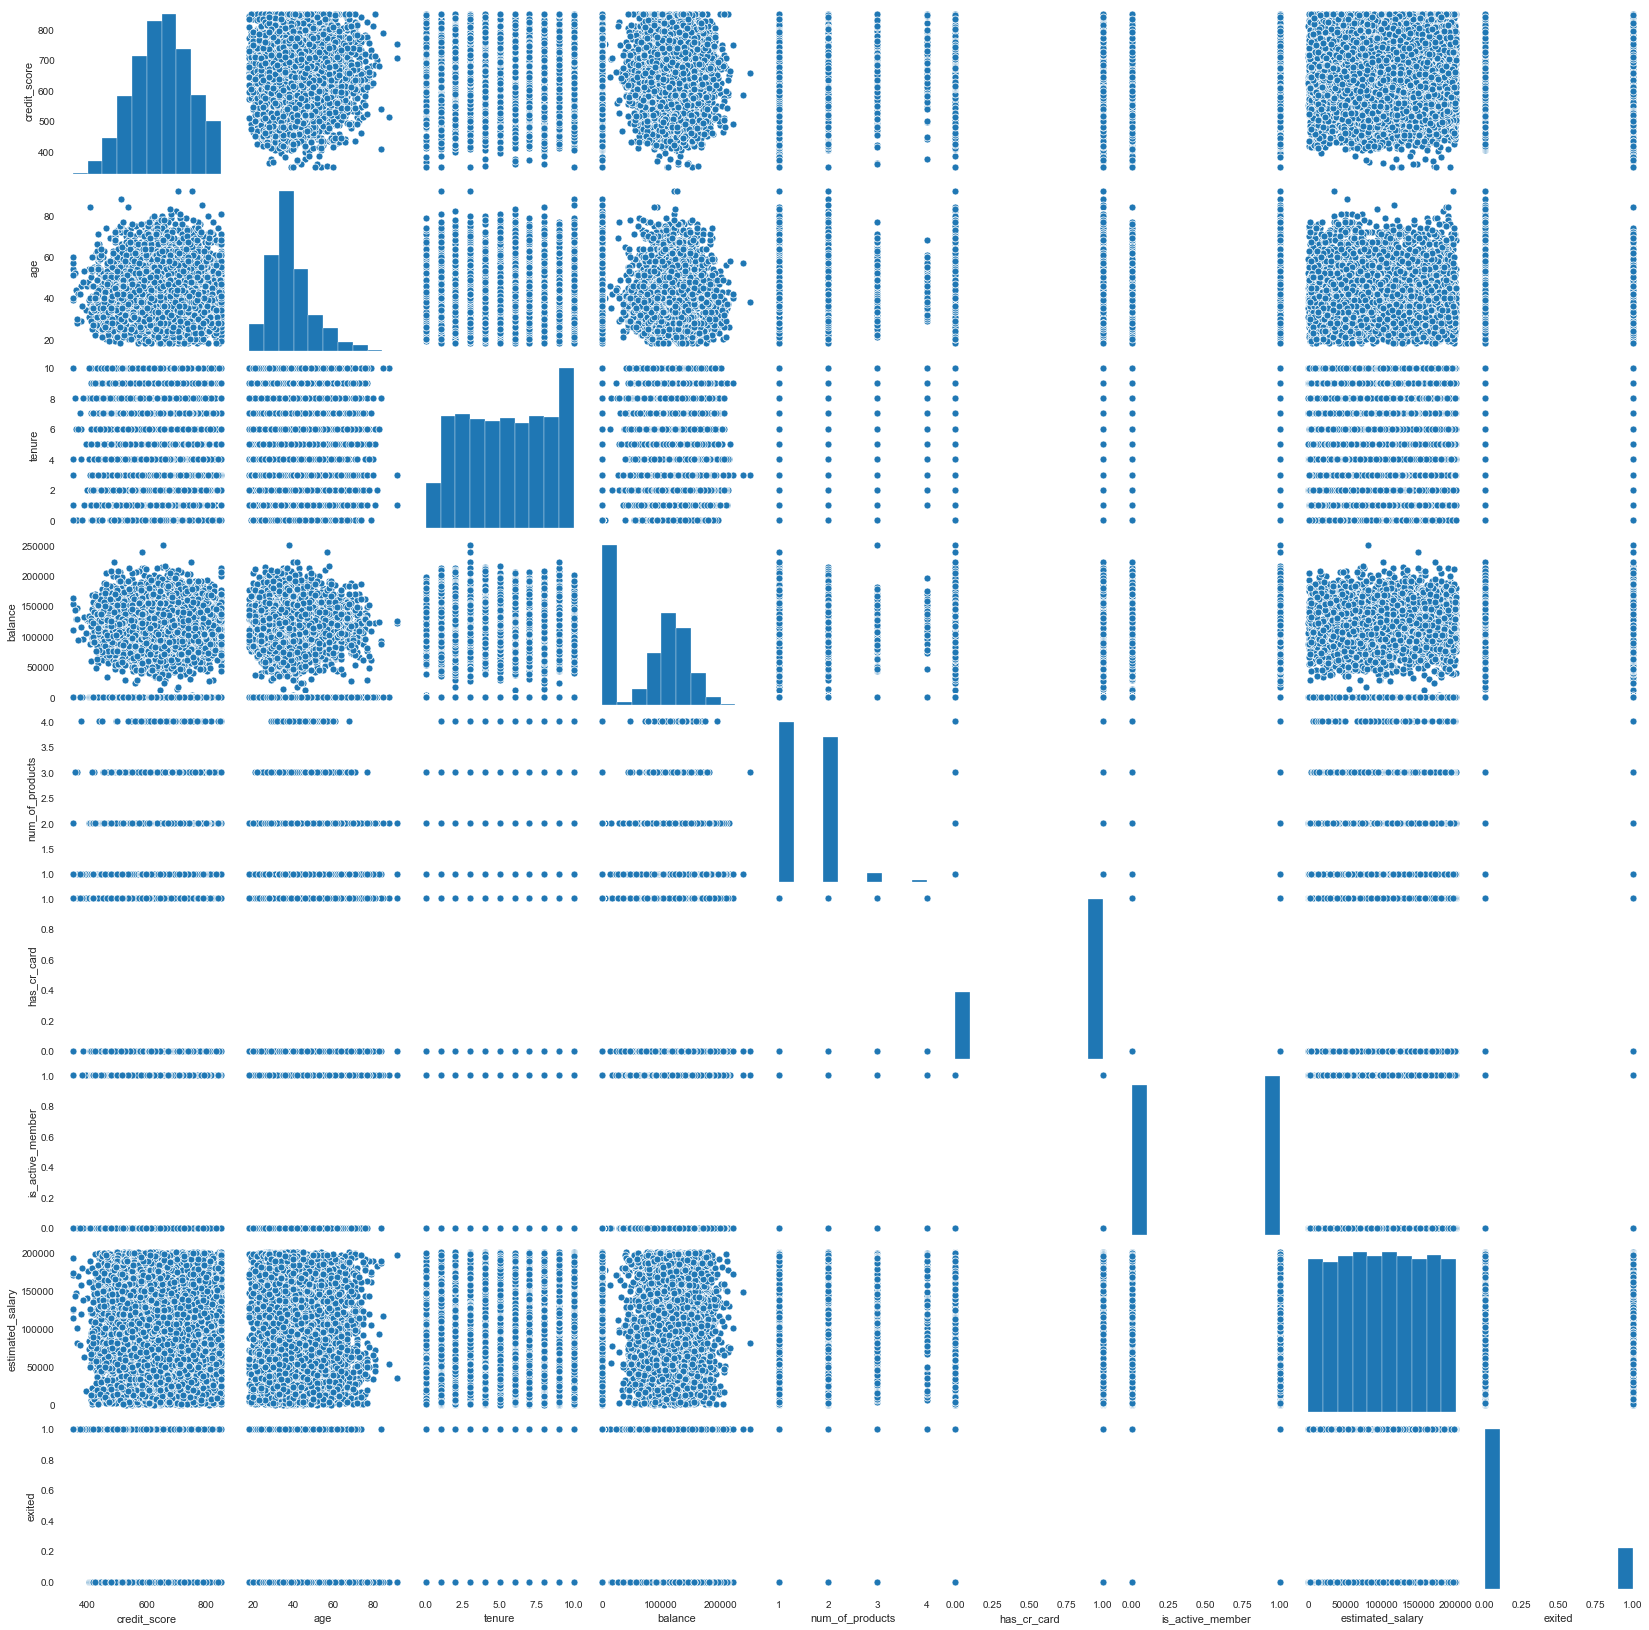

In [59]:
sns.pairplot(num.drop('customer_id',axis=1));

# 5.0 Data Preparation

In [60]:
df5 = df4.copy()

## 5.1. Categorical Variables

In [61]:
# One-hot Encoding - Geography
df5 = pd.get_dummies( df5, prefix=['geography'], columns=['geography'] )

# Label encoding - Gender
df5['gender'] = [1 if gender == 'Male' else 2 for gender in df5['gender']]

## 5.2 Numerical Variables

In [62]:
# Normalization - Almost normal distribution features
ss = StandardScaler()

df5['age'] = ss.fit_transform(df5[['age']].values)
df5['credit_score'] = ss.fit_transform(df5[['credit_score']].values)

# Rescaling - Non-Normal distribuited features
mms = MinMaxScaler(feature_range=(0, 1))

df5['tenure'] = mms.fit_transform(df5[['tenure']].values)
df5['estimated_salary'] = mms.fit_transform(df5[['estimated_salary']].values)
df5['anual_revenue'] = mms.fit_transform(df5[['anual_revenue']].values)

# Robust Scaler
rs = RobustScaler()

df5['balance'] = rs.fit_transform(df5[['balance']].values)

In [63]:
# Check data preparation
df5.head()

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,anual_revenue,geography_France,geography_Germany,geography_Spain
0,-0.326221,2,0.293517,0.2,-0.761480,1,1,1,0.506735,1,0.506742,1,0,0
1,-0.440036,2,0.198164,0.1,-0.104906,1,0,1,0.562709,0,0.562715,0,0,1
2,-1.536794,2,0.293517,0.8,0.489346,3,1,0,0.569654,1,0.569661,1,0,0
3,0.501521,2,0.007457,0.1,-0.761480,2,0,0,0.469120,0,0.351835,1,0,0
4,2.063884,2,0.388871,0.2,0.221806,1,1,1,0.395400,0,0.296546,0,0,1


## 5.3 Balancing Data - Oversampling with SMOTE

In [64]:
# Using SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(df5.loc[:,df5.columns != 'exited'], df5.exited)

In [65]:
print("The dataset's shape after the balancing has {} observations.".format(X_smote.shape[0]))

The dataset's shape after the balancing has 15926 observations.


# 6.0 Feature Selection

In [66]:
df6 = df5.copy()

## 6.1 Train and Test Datasets

In [67]:
# Already balanced X and Y
X=X_smote
y=y_smote

# Train and test spliT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

## 6.2 Boruta 

Boruta Feature Selection did not make any difference for the better performance of the model.

In [68]:
# # Prepate train and test sets for Boruta (From DataFrame to Numpy array)
# X_train_n = X_train.values
# y_train_n = y_train.values

# # Define RandomForest Regressor
# rf = RandomForestRegressor(n_jobs=-1)
# rc = RandomForestClassifier(n_jobs=-1)

# # Define Boruta
# boruta = BorutaPy(rc, n_estimators='auto', random_state=42).fit(X_train_n,y_train_n)

In [69]:
# # Columns selected
# cols_selected = boruta.support_.tolist()

# # Feature selection

# X_train = X_train.iloc[:,cols_selected]
# X_test = X_test.iloc[:,cols_selected]

# 7.0 Machine Learning Modelling

In [70]:
df7 = df6.copy()

In [71]:
## Models
# Logistic Regression
# Naive Bayes
# XGBoost
# Support Vector Classification
# Random Forest Classifier

## Try Calibration Plot (reliability curve)

### 7.1.1 Logistic Regression - Cross Validation

In [72]:
# Model definition

logistic = LogisticRegression(random_state=42)

In [73]:
cross_validation(X_train, y_train, 10, 'Logistic Regression', logistic, verbose=True)

Fold Nº: 1/10
Fold Nº: 2/10
Fold Nº: 3/10
Fold Nº: 4/10
Fold Nº: 5/10
Fold Nº: 6/10
Fold Nº: 7/10
Fold Nº: 8/10
Fold Nº: 9/10
Fold Nº: 10/10


,Model Name,Avg F1-Score
0,Logistic Regression,0.713+/-0.014


### 7.1.2 Logistic Regression - Prediction

In [74]:
# Model Training
logistic.fit(X_train, y_train)

# Prediction 
pred = logistic.predict(X_test)

# # Predict Probabilitie in the whole dataset
# df7['score'] = logistic.predict_proba(df5[X_train.columns])[:,1]
# df7['score'] = df['score'].apply(lambda x : round(x,2))

# Performance
f1_score_metric('Logistic Regression',y_test,pred)

,Model Name,F1 Score
0,Logistic Regression,0.696


### 7.1.3 Logistic Regression - Calibration Curve

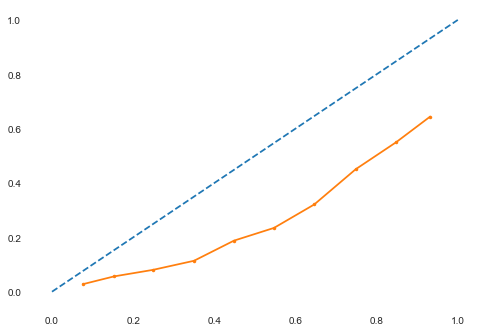

In [75]:
# Predict probabilities for X test
prob_log_full = logistic.predict_proba(df7[X_test.columns])[:,1]

fop, mpv = calibration_curve(df7.exited, prob_log_full, n_bins=10)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(mpv,fop, marker='.')
plt.show()

### 7.2.1 SVC - Cross Validation

In [76]:
# Model definition

svc = SVC(random_state=42)

# Cross Validation
cross_validation(X_train, y_train, 10, 'SVC', svc, verbose=True)

Fold Nº: 1/10
Fold Nº: 2/10
Fold Nº: 3/10
Fold Nº: 4/10
Fold Nº: 5/10
Fold Nº: 6/10
Fold Nº: 7/10
Fold Nº: 8/10
Fold Nº: 9/10
Fold Nº: 10/10


,Model Name,Avg F1-Score
0,SVC,0.803+/-0.016


### 7.2.2 SVC -Prediction

In [77]:
# Model Training
svc.fit(X_train, y_train)

# Prediction 
pred_svc = svc.predict(X_test)

# Performance
f1_svc = f1_score_metric('SVC',y_test,pred_svc)
f1_svc

,Model Name,F1 Score
0,SVC,0.803


### 7.2.3 SVC - Calibration Curve

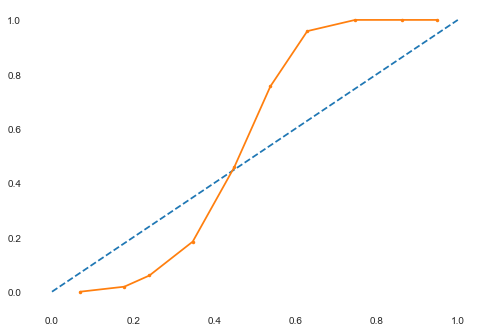

In [78]:
## WITHOUT CALIBRATION
# Predict probabilities for X test
prob_svc_full = svc.decision_function(df7[X_test.columns])

fop, mpv = calibration_curve(df7.exited, prob_svc_full, n_bins=10, normalize=True)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(mpv,fop, marker='.')
plt.show()

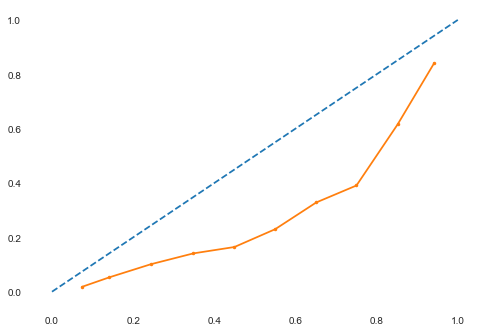

In [79]:
## CALIBRATION WITH CalibratedClassifierCV
calibration = CalibratedClassifierCV(svc, method='sigmoid',cv=5)
calibration.fit(X_train,y_train)

# Predict probabilities for X test
prob_svc_full = calibration.predict_proba(df7[X_test.columns])[:,1]

fop, mpv = calibration_curve(df7.exited, prob_svc_full, n_bins=10, normalize=True)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(mpv,fop, marker='.')
plt.show()

### 7.3.1 XGBoost - Cross Validation

In [80]:
# Model definition

xgb = XGBClassifier(random_state=42)

# Cross Validation

cross_validation(X_train, y_train, 10, 'XGBoost', xgb, verbose=True)

Fold Nº: 1/10
[15:37:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold Nº: 2/10
[15:37:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold Nº: 3/10
[15:38:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold Nº: 4/10
[15:38:04] WAR

,Model Name,Avg F1-Score
0,XGBoost,0.901+/-0.008


### 7.3.2 XGBoost - Prediction

In [81]:
# Model Training
xgb.fit(X_train, y_train)

# Prediction 
pred_xgb = xgb.predict(X_test)

# Performance
f1_xgb = f1_score_metric('XGBoost',y_test,pred_xgb)
f1_xgb

[15:38:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model Name,F1 Score
0,XGBoost,0.905


### 7.3.3 XGBoost - Calibration Curve

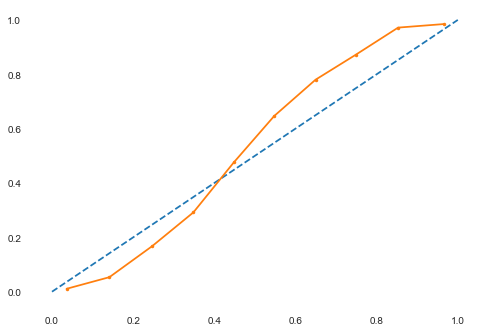

In [82]:
## WITHOUT CALIBRATION
# Predict probabilities for THE WHOLE DATASET
prob_xgb_full = xgb.predict_proba(df7[X_test.columns])[:,1]

fop, mpv = calibration_curve(df7.exited, prob_xgb_full, n_bins=10, normalize=True)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(mpv,fop, marker='.')
plt.show()

[15:38:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

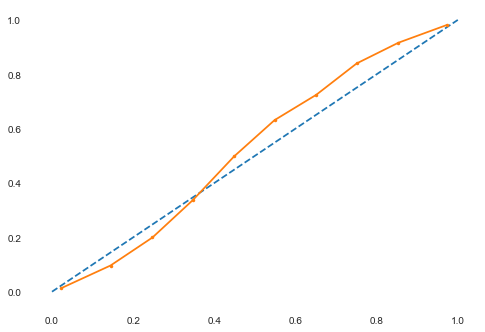

In [83]:
## CALIBRATION WITH CalibratedClassifierCV
calibration = CalibratedClassifierCV(xgb, method='sigmoid',cv=5)
calibration.fit(X_train,y_train)

# Predict probabilities for THE WHOLE DATASET
prob_xgb_full = calibration.predict_proba(df7[X_test.columns])[:,1]

fop, mpv = calibration_curve(df7.exited, prob_xgb_full, n_bins=10, normalize=True)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(mpv,fop, marker='.')
plt.show()

### 7.4.1 Random Forest Classifier - Cross Validation

In [84]:
# Model Definition
rfc = RandomForestClassifier(random_state=42)

# Cross Validation
cross_validation(X_train, y_train, 10, 'Random Forest Classifier', rfc, verbose=True)

Fold Nº: 1/10
Fold Nº: 2/10
Fold Nº: 3/10
Fold Nº: 4/10
Fold Nº: 5/10
Fold Nº: 6/10
Fold Nº: 7/10
Fold Nº: 8/10
Fold Nº: 9/10
Fold Nº: 10/10


,Model Name,Avg F1-Score
0,Random Forest Classifier,0.887+/-0.01


### 7.4.2 Random Forest Classifier - Prediction

In [85]:
# Model training
rfc.fit(X_train, y_train)

# Prediction
pred_rfc = rfc.predict(X_test)

# Model performance
f1_rfc = f1_score_metric('Random Forest Classifier', y_test,pred_rfc)
f1_rfc

,Model Name,F1 Score
0,Random Forest Classifier,0.9


### 7.4.3 Random Forest Classifier - Calibration Curve

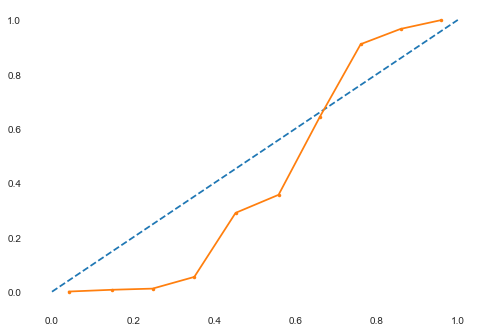

In [86]:
## WITHOUT CALIBRATION
# Predict probabilities for THE WHOLE DATASET
prob_rfc_full = rfc.predict_proba(df7[X_test.columns])[:,1]

fop, mpv = calibration_curve(df7.exited, prob_rfc_full, n_bins=10, normalize=True)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(mpv,fop, marker='.')
plt.show()

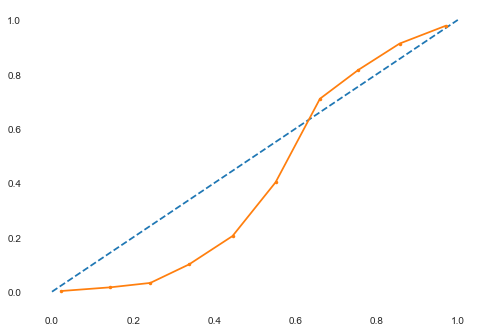

In [87]:
## CALIBRATION WITH CalibratedClassifierCV
calibration = CalibratedClassifierCV(rfc, method='sigmoid',cv=5)
calibration.fit(X_train,y_train)

# Predict probabilities for THE WHOLE DATASET
prob_rfc_full = calibration.predict_proba(df7[X_test.columns])[:,1]

fop, mpv = calibration_curve(df7.exited, prob_rfc_full, n_bins=10, normalize=True)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(mpv,fop, marker='.')
plt.show()

# 8.0 Hyperparameter Fine-Tunning

In [88]:
df8 = df7.copy()

# 9.0 Model Perfomance

In [89]:
df9= df8.copy()

## 9.1 Precision

How many clients classified as churn are, in fact, in churn? (TP/TP + FP)

In [90]:
# precision_score(pred, y_test)

**Before balancing**: 0.21804511278195488

## 9.2 Recall

Out of all clients that are,in fact, in churn, how many we got correctly classified?

In [91]:
# recall_score(pred, y_test)

**Before balacing:** 0.5403726708074534

## 9.1 F1 Score

Balance mean between precision (How many clients classified as churn are, in fact, in churn?) and recall (Out of all clients that are,in fact, in churn, how many we got correctly classified?).

In [92]:
f1_score(pred,y_test).round(3)

0.696

In [93]:
f1_score_metric('Logistic Regression',y_test,pred)

,Model Name,F1 Score
0,Logistic Regression,0.696


# 10.0 Deploy

##### 